## Los datos
- Grupo
- Sexo
- Edad
- Modo_Llegada
- Lesión
- Queja_Principal
- Estado_Mental
- Dolor
- Dolor_NRS
- SBP
- DBP
- HR
- RR
- BT
- Saturación
- KTAS_Enfermera
- Diagnóstico_Urgencias
- Disposición
- KTAS_Experto
- Grupo_Error
- Duración_Estancia_Min
- Duración_KTAS_Min
- Error_Triaje


In [2]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

## 1. Carga de los datos

In [3]:
datos = pd.read_csv("./data/Regresión_train_data.csv")

In [4]:
datos.shape

(1000, 23)

In [5]:
datos.dtypes

Grupo                         int64
Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [6]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
559,1,2,62,3,1,"pain, abdominal",1,1,5,136.0,...,36.6,NaN,3,Abdominal pain,1,3,0,360,"7,57",0
996,1,1,27,3,1,Suicidal Attempt,1,0,#BOÞ!,110.0,...,36.2,NaN,3,Suicide tendency,2,3,0,442,"7,42",0
27,2,2,44,3,1,dyspnea,1,1,3,130.0,...,37.1,98.0,3,Acute HIV infection syndrome,1,3,0,9891,"3,00",0
485,2,1,36,3,1,Vaginal Bleeding,1,1,3,120.0,...,36.4,98.0,4,"Ectopic pregnancy, unspecified",1,4,0,477,"4,00",0
192,1,1,43,3,2,"injury, finger",1,1,4,191.0,...,36.5,NaN,4,Injury of finger,1,4,0,210,"3,32",0


## 2. Entendimiento de los datos

Variables numericas candidatas a utilizar

In [7]:
candidatas = ["Sexo","Edad","Modo_Llegada","Lesion","Estado_Mental","Dolor","KTAS_enfermera","Disposicion","KTAS_experto","Duracion_KTAS_Min", "EWS", "SI"]

In [8]:
datos.describe()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,983.000000,979.000000,988.000000,985.000000,989.000000,444.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.450000,1.514000,53.892000,2.811000,1.2000,1.103000,0.562000,133.485249,79.566905,84.400810,19.450761,36.562993,97.047297,3.328000,1.610000,3.260000,0.569000,12792.480000,0.253000
std,0.497743,0.500054,19.826483,0.796186,0.4002,0.431946,0.496389,27.156136,15.174593,16.297428,2.069882,0.519699,4.761112,0.862067,1.161572,0.865534,1.587375,87721.151446,0.630387
min,1.000000,1.000000,16.000000,1.000000,1.0000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,36.000000,2.000000,1.0000,1.000000,0.000000,114.000000,70.000000,73.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,132.750000,0.000000
50%,1.000000,2.000000,56.000000,3.000000,1.0000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,270.500000,0.000000
75%,2.000000,2.000000,70.250000,3.000000,1.0000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,99.000000,4.000000,2.000000,4.000000,0.000000,620.000000,0.000000
max,2.000000,2.000000,94.000000,7.000000,2.0000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,39.800000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,2.000000


In [9]:
datos["Sexo"].value_counts()


Sexo
2    514
1    486
Name: count, dtype: int64

In [10]:
datos["dolor_NRS"].value_counts()

dolor_NRS
#BOÞ!    440
3        209
4        111
5        109
6         59
2         31
7         27
8          8
10         3
1          2
9          1
Name: count, dtype: int64

In [11]:
datos["Error_Triaje"].value_counts()

Error_Triaje
0    851
2    104
1     45
Name: count, dtype: int64

In [12]:
datos["Grupo_De_Error"].value_counts().sort_index()


Grupo_De_Error
0    851
1     16
2     39
3      6
4     50
5     11
6      6
7      7
8      9
9      5
Name: count, dtype: int64

In [13]:
datos["Queja_Principal"].value_counts().sort_index()

Queja_Principal
??                       5
?? ??                    1
?? ???                   2
?? ??? ??                1
???                      3
                        ..
weakness                 1
whirling type vertigo    3
wrist laceration         1
wrist pain, Lt           1
wrist pain, Rt           1
Name: count, Length: 347, dtype: int64

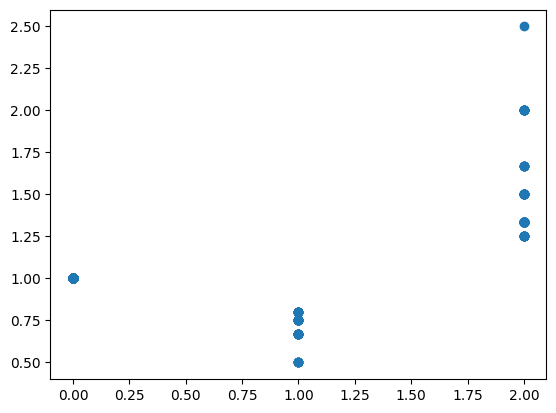

In [14]:
datos[["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a = datos[datos["KTAS_enfermera"]!=datos["KTAS_experto"]][["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a[a["Error_Triaje"]==1]
plt.scatter(datos["Error_Triaje"], datos["KTAS_enfermera"]/datos["KTAS_experto"])


In [15]:
def calcularEWS(registro):
    total = 0
    # Frecuencia respiratoria (RR)
    if registro['RR'] <= 8:
        total += 3
    elif 9 <= registro['RR'] <= 11:
        total += 1
    elif 21 <= registro['RR'] <= 24:
        total += 2
    elif registro['RR'] >= 25:
        total += 3
    # Presión arterial sistólica (SBP)
    if registro['SBP'] <= 90:
        total += 3
    elif 91 <= registro['SBP'] <= 100:
        total += 2
    elif 101 <= registro['SBP'] <= 110:
        total += 1
    elif registro['SBP'] >= 220:
        total += 3
    # Frecuencia cardíaca (HR)
    if registro['HR'] <= 40:
        total += 3
    elif 41 <= registro['HR'] <= 50:
        total += 1
    elif 91 <= registro['HR'] <= 110:
        total += 1
    elif 111 <= registro['HR'] <= 130:
        total += 2
    elif registro['HR'] >= 131:
        total += 3
    # Temperatura corporal (BT)
    if registro['BT'] < 35.0:
        total += 3
    elif 35.0 <= registro['BT'] <= 36.0:
        total += 1
    elif 38.1 <= registro['BT'] <= 39.0:
        total += 1
    elif registro['BT'] > 39.0:
        total += 2
    
    # Nivel de conciencia
    if registro['Estado_Mental'] != 1:
        total += 3
    
    return total

# Función para calcular el Shock Index (SI)
def calculateSI(registro):
    return registro['HR'] / registro['SBP']


datos['EWS'] = datos.apply(calcularEWS, axis=1)
datos['SI'] = datos.apply(calculateSI, axis=1)
print(datos.head())

   Grupo  Sexo  Edad  Modo_Llegada  Lesion  Queja_Principal  Estado_Mental  \
0      2     2    49             2       1  ant. chest pain              1   
1      2     2    30             4       1         headache              1   
2      2     1    61             3       2  ant. chest pain              1   
3      2     2    61             3       1         headache              1   
4      1     2    67             3       1    fever & chill              1   

   Dolor dolor_NRS    SBP  ...  KTAS_enfermera  \
0      1         2  150.0  ...               2   
1      1         4  140.0  ...               3   
2      1         3  100.0  ...               4   
3      1         4  120.0  ...               4   
4      0     #BOÞ!  143.0  ...               4   

                Diagnostico_En_Urgencias  Disposicion  KTAS_experto  \
0                   Ischaemic chest pain            2             2   
1  Subarachnoid haemorrhage, unspecified            7             3   
2      Contusion 

In [16]:
datos.sample(10)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,SI
494,2,2,47,2,2,lower extremity paraparesis,1,1,6,110.0,...,2,"Stress fracture of vertebra, Cervical region",2,2,0,399,"4,00",0,2,0.709091
907,1,2,18,1,1,abd pain,1,1,5,107.0,...,3,Abdominal pain,1,3,0,0,"6,00",0,3,1.018692
301,1,2,69,3,2,right leg injury,1,1,4,145.0,...,4,Multiple abrasion,1,4,0,22,"5,00",0,0,0.531034
378,2,1,76,3,1,Abd. pain,1,1,3,120.0,...,4,Chronic viral hepatitis C,1,4,0,645,"3,00",0,1,0.816667
513,2,1,31,4,1,dyspnea,1,0,#BOÞ!,90.0,...,3,Cough with dyspnea,2,3,0,9619,"5,00",0,4,1.144444
997,1,2,54,2,1,"pain, chest",1,1,6,159.0,...,2,Gastroesophageal reflux disease,1,2,0,214,"4,95",0,1,0.572327
525,1,2,65,3,1,dyspnea,1,0,#BOÞ!,206.0,...,3,Chronic obstructive pulmonary disease severe,1,3,0,134,"12,88",0,3,0.495146
595,1,2,88,3,1,Nasal swelling,1,0,#BOÞ!,124.0,...,4,Abscess of nose,1,4,0,159,"10,67",0,1,0.846774
711,2,1,76,3,1,diarrhea,1,1,4,100.0,...,4,Acute watery diarrhoea,1,4,0,690,"4,00",0,2,0.780000
47,2,1,89,4,1,melena,1,0,#BOÞ!,70.0,...,2,"Gastrointestinal haemorrhage, unspecified",2,2,0,9485,"2,00",0,3,1.171429


Análisis de completitud

In [17]:
datos.isnull().sum() / datos.shape[0]

Grupo                       0.000
Sexo                        0.000
Edad                        0.000
Modo_Llegada                0.000
Lesion                      0.000
Queja_Principal             0.000
Estado_Mental               0.000
Dolor                       0.000
dolor_NRS                   0.000
SBP                         0.017
DBP                         0.021
HR                          0.012
RR                          0.015
BT                          0.011
Saturacion                  0.556
KTAS_enfermera              0.000
Diagnostico_En_Urgencias    0.001
Disposicion                 0.000
KTAS_experto                0.000
Grupo_De_Error              0.000
Duracion_Estancia_Min       0.000
Duracion_KTAS_Min           0.000
Error_Triaje                0.000
EWS                         0.000
SI                          0.017
dtype: float64

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

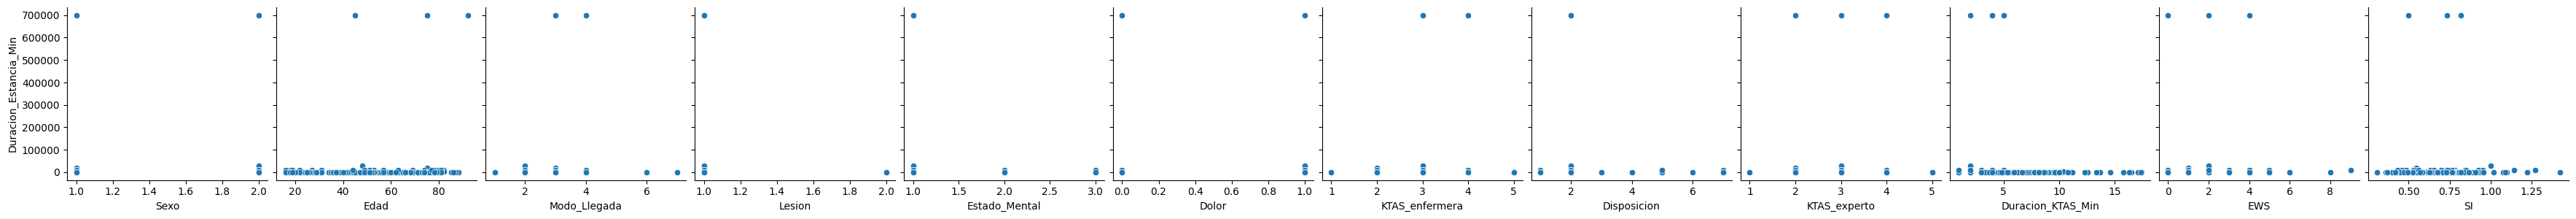

In [19]:
datos["Duracion_KTAS_Min"] = datos["Duracion_KTAS_Min"].str.replace(',', '.').astype('float64')
sns.pairplot(datos.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=candidatas, kind="scatter")

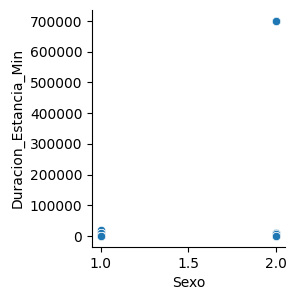

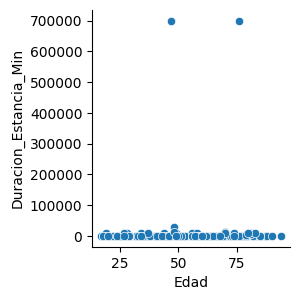

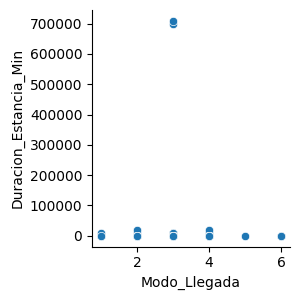

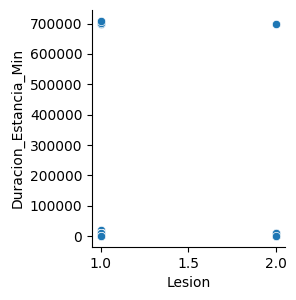

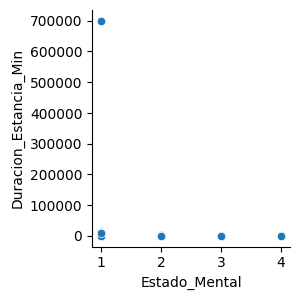

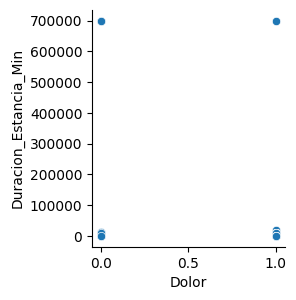

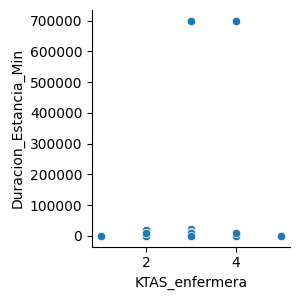

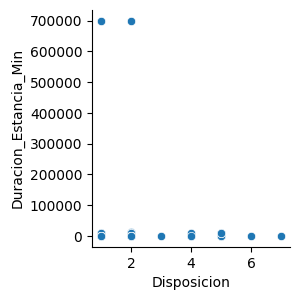

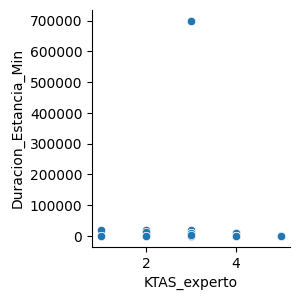

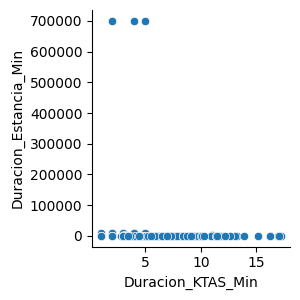

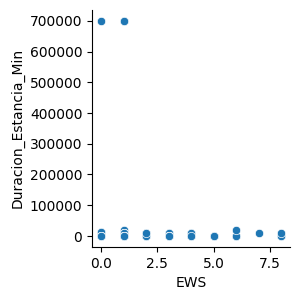

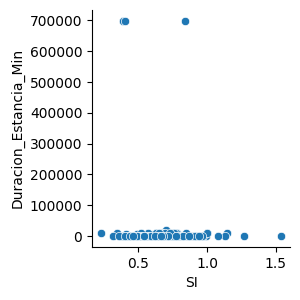

In [20]:
for variable in candidatas:
    sns.pairplot(datos.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

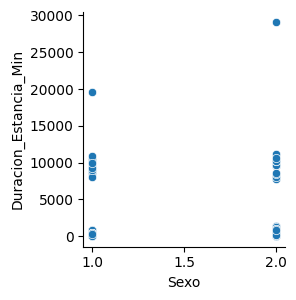

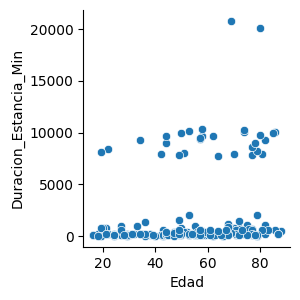

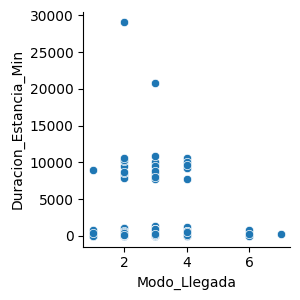

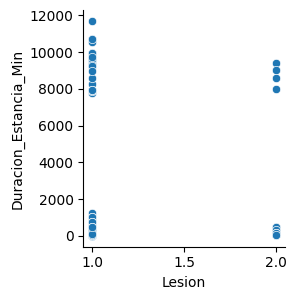

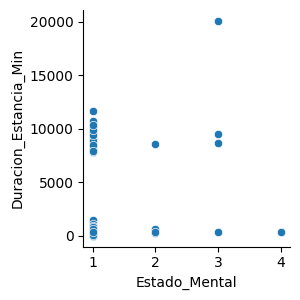

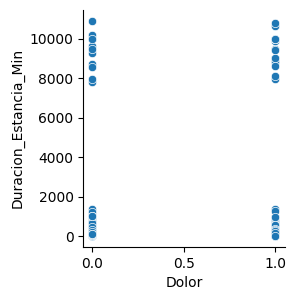

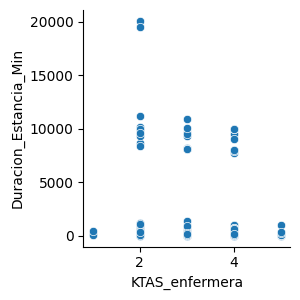

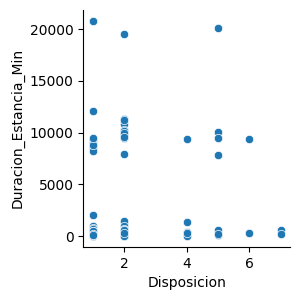

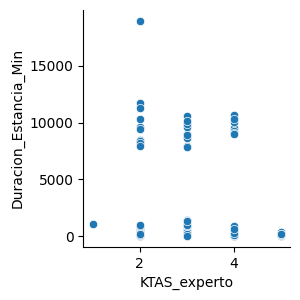

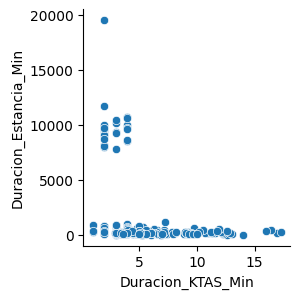

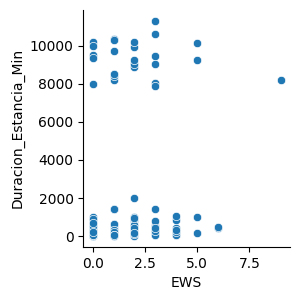

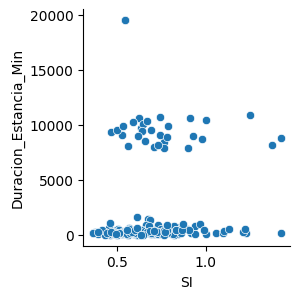

In [21]:
prueba=datos[datos["Duracion_Estancia_Min"]<=100000]
for variable in candidatas:
    sns.pairplot(prueba.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

<Axes: >

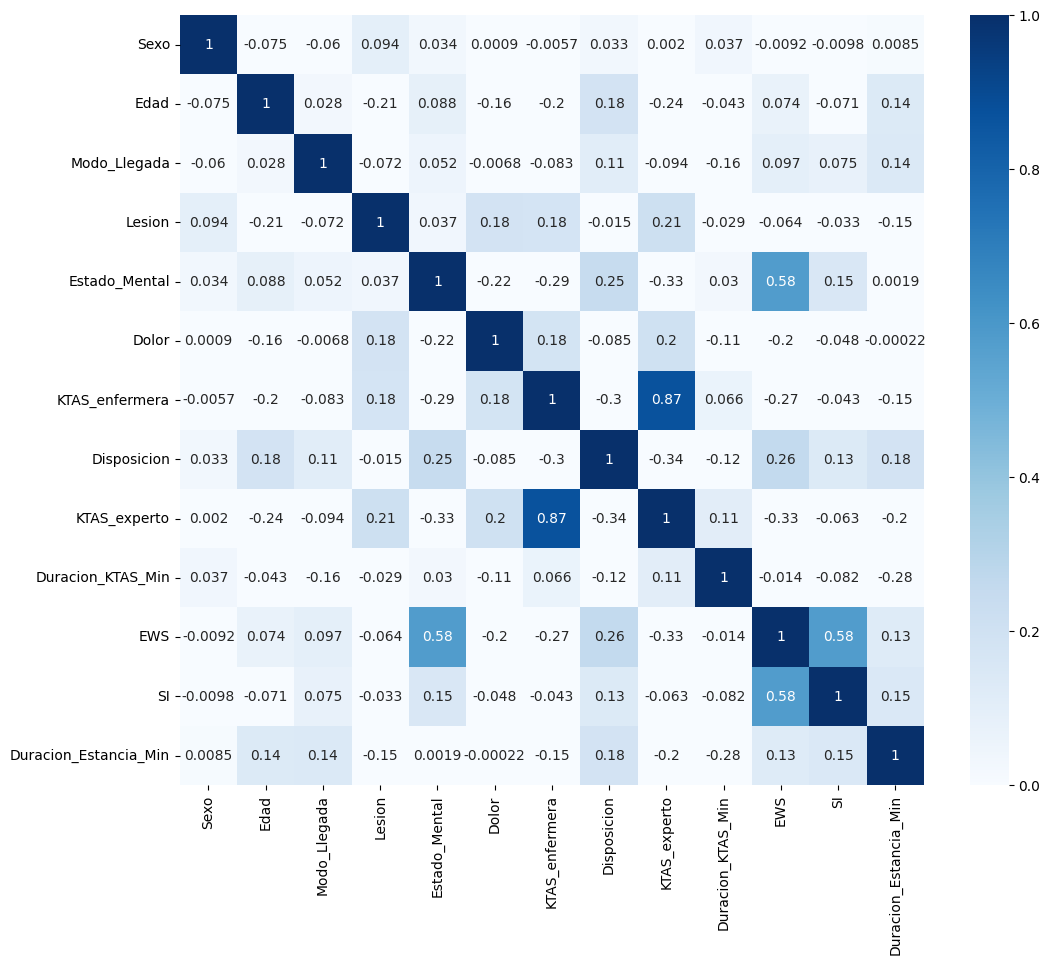

In [22]:
plt.figure(figsize=(12, 10))
sns.heatmap(prueba[candidatas+['Duracion_Estancia_Min']].corr(), cmap="Blues", vmin=0, vmax=1, annot = True)

### 2.2. Búsqueda de relaciones entre las variables de entrada

**Importante:** La regresión lineal asume que sus variables de entrada no se encuentran altamente correlacionados.

<Axes: >

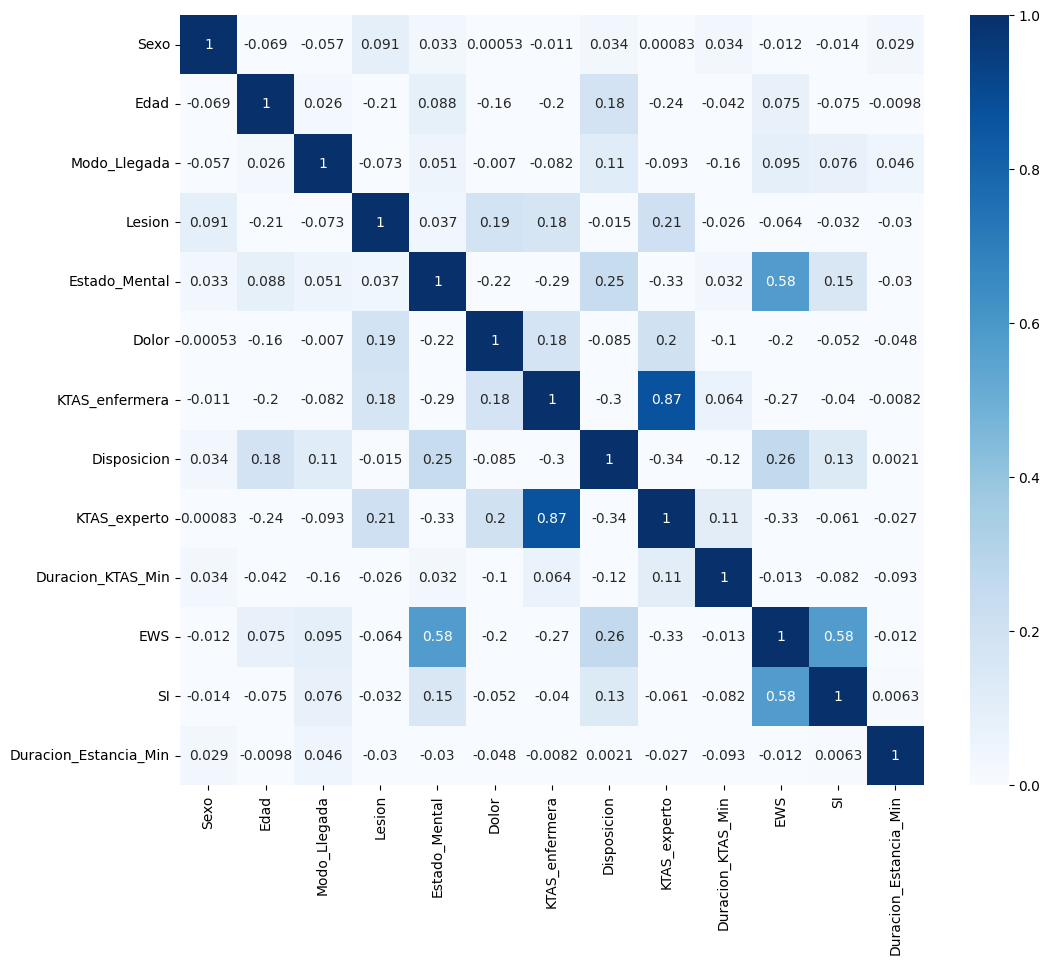

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(datos[candidatas+['Duracion_Estancia_Min']].corr(), cmap="Blues", vmin=0, vmax=1, annot = True)

## 3. Preparación de datos

### 3.1. Relacionado con la calidad de los datos

In [ ]:
# Se eliminan los registros totalmente duplicados
datos = datos.dropna(subset=["Duracion_Estancia_Min"]+candidatas)

In [ ]:
datos.shape
total_rows = datos.shape[0]
total_rows

983

In [ ]:
datos[["Duracion_Estancia_Min"]+candidatas].isnull().sum() / datos.shape[0]

Duracion_Estancia_Min    0.0
Sexo                     0.0
Edad                     0.0
Modo_Llegada             0.0
Lesion                   0.0
Estado_Mental            0.0
Dolor                    0.0
KTAS_enfermera           0.0
Disposicion              0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
EWS                      0.0
SI                       0.0
dtype: float64

In [ ]:
datos[datos[["Duracion_Estancia_Min"]+candidatas] == '#BOÞ!'][["Duracion_Estancia_Min"]+candidatas].count()/ datos.shape[0]

Duracion_Estancia_Min    0.0
Sexo                     0.0
Edad                     0.0
Modo_Llegada             0.0
Lesion                   0.0
Estado_Mental            0.0
Dolor                    0.0
KTAS_enfermera           0.0
Disposicion              0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
EWS                      0.0
SI                       0.0
dtype: float64

In [ ]:
datos.loc[datos.duplicated(subset=candidatas, keep=False)].head(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
20,1,2,78,3,1,dizziness,1,0,#BOÞ!,132.0,...,36.8,NaN,3,Dizziness,1,3,0,129,5.38,0
55,2,2,40,3,1,"Leg pain, NOS",1,1,3,110.0,...,36.4,NaN,5,Complex regional pain syndrome type II,1,5,0,60,2.00,0
71,2,1,41,3,2,Open Wound,1,1,3,130.0,...,36.6,98.0,4,"Open wound of head, part unspecified",1,4,0,125,4.00,0
87,1,1,81,2,1,dizziness,1,0,#BOÞ!,154.0,...,35.7,NaN,3,Dizziness,1,3,0,332,3.88,0
99,1,1,22,2,2,headache,1,1,5,106.0,...,36.5,NaN,3,Multiple abrasion,1,3,0,148,6.87,0


In [ ]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas, keep=False)].shape[0]
duplicated_rows

65

In [ ]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 6.6124%


In [ ]:
datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].tail(4)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,SI
996,1,1,27,3,1,Suicidal Attempt,1,0,#BOÞ!,110.0,...,3,Suicide tendency,2,3,0,442,7.42,0,2,0.872727
997,1,2,54,2,1,"pain, chest",1,1,6,159.0,...,2,Gastroesophageal reflux disease,1,2,0,214,4.95,0,1,0.572327
998,1,1,19,3,1,eye discomfort,1,0,#BOÞ!,132.0,...,4,Corneal erosion,1,4,0,50,3.45,0,1,0.689394
999,1,2,29,3,1,"pain, abdominal",1,1,6,137.0,...,3,Allergic reaction,1,3,0,116,5.97,0,0,0.423358


In [ ]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].shape[0]
duplicated_rows

65

In [ ]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 6.6124%


In [ ]:
datos.drop_duplicates(subset=candidatas, inplace=True)
datos.drop_duplicates(subset=candidatas+["Duracion_Estancia_Min"], inplace=True)

In [ ]:
datos.shape

(950, 25)